## Carregando o dataset

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:

df_train = pd.read_csv('./assets/train.csv')
df_test = pd.read_csv('./assets/test.csv')
df_gender = pd.read_csv('./assets/gender_submission.csv')

df_test = df_test.merge(df_gender, on="PassengerId", how="left")
df = pd.concat([df_train, df_test], ignore_index=True)


In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1308 non-null   float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1308.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.376911,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.484798,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


## Pre-processamento

Remoção de features que não serão ultilizadas

In [9]:
df.drop(columns=['Cabin', 'Ticket', 'PassengerId', 'Embarked'], inplace=True)

In [10]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['family_members'] = df['Parch'] + df['SibSp'] + 1

SibSp: Irmãos e conjuges. Parch: Pais e filhos. Somatório é o total de parentes 

In [11]:
df[df['Survived'].isnull()] = 1

### Buscando por correlações para preencher os valores de age

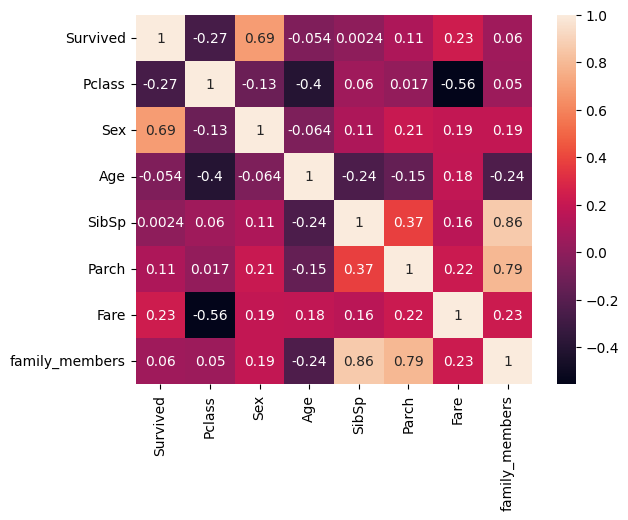

In [12]:
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True)
plt.show()

In [13]:
df.groupby(['Pclass', 'Sex', 'family_members'])['Age'].median()

Pclass  Sex  family_members
1       0    1                 42.00
             2                 38.00
             3                 49.50
             4                 20.50
             5                 37.00
             6                 41.50
        1    1                 35.00
             2                 36.00
             3                 45.00
             4                 25.00
             5                 21.00
             6                 26.00
2       0    1                 30.00
             2                 33.25
             3                 21.50
             4                 25.00
        1    1                 30.00
             2                 28.00
             3                 24.00
             4                 22.00
             5                 54.00
             6                 24.00
3       0    1                 26.00
             2                 25.00
             3                 17.50
             4                 26.00
          

In [14]:
df['Age'] = df.Age.fillna(
    df.groupby(['Pclass', 'Sex', 'family_members'])['Age'].transform('median')
    )

<Axes: ylabel='Frequency'>

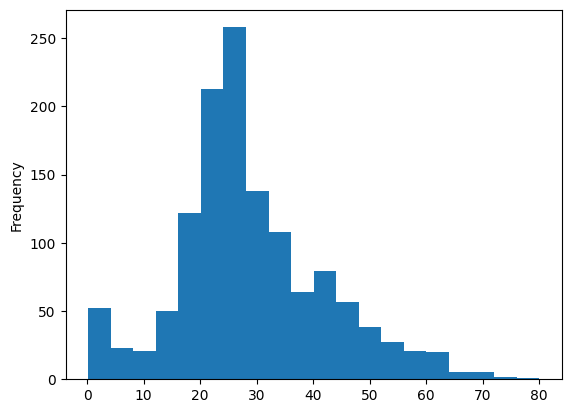

In [15]:
df.Age.plot.hist(bins=20)

### Look at the Fare outliers

<Axes: >

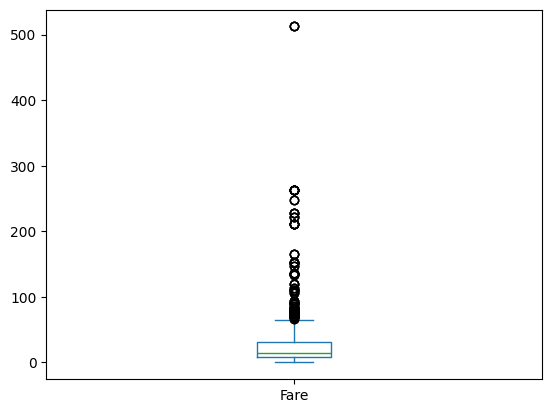

In [16]:
df.Fare.plot.box()

In [17]:
# Remove the biggest value
#df.loc[df['Fare'] == df['Fare'].max(), 'Fare'] = df.Fare.median()

Mesmo sendo um outlier, o valor mais discrimidado é correto, e por tanto não é nessasário, no conxto dessa pesquisa, remove-lo.   
Vamos entender melhor a relação entre o valor pago e a classe de passageiro. Em teoria, aqueles que pagaram mais estão em melhores classes.  

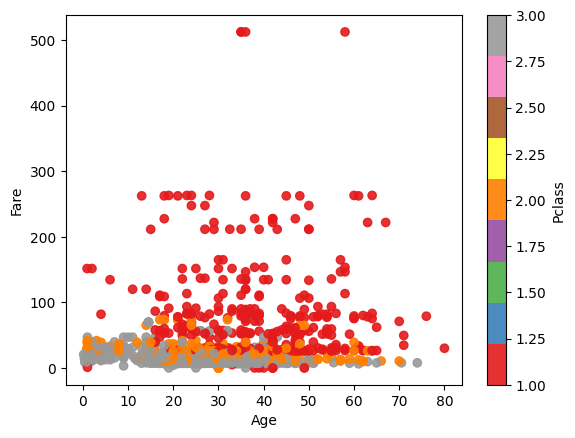

In [18]:
scatter = plt.scatter(
    df['Age'], 
    df['Fare'], 
    c=df['Pclass'], cmap='Set1',
    alpha=0.9)

plt.colorbar(scatter, label='Pclass')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.show()

Contraintuitivamente, houveram pessoas na terceira classe que pagaram o mesmo valor que outras na primeira. Não havia uma descrição maior no dataset do kaggle, portanto não é possível dizer exatamente como funciona a coluna Fare.   
Hipótese: Passageiros que pagaram barato eram convidados.   
  
Como existem pessoas da primeira classe que pagaram diferentes valores:   
Hipótese: Haviam cabines de preços variados em cada uma das classes.
   
Neste caso, infomações adicionais sobre a coluna Fare precisariam ser repassadas.

## Exploração dos dados

Investigações:
* Pessoas que viajaram em família tem maiores chances de sobreviver?
* Aqueles com maior pretígio social (medido pela classe de passagem) tem mais chances de sobreviver?
*  Pessoas em grupo de risco; crianças, idosos e mulheres foram priorizadas?

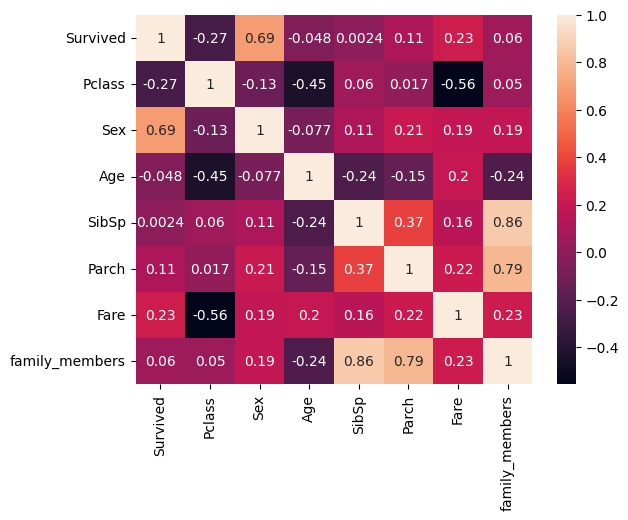

In [19]:
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True)
plt.show()

Heatmap após o tratamento. O número de parentes não parece ter relação com a sobrevivência, vamos ver isso mais de perto. 

<Axes: xlabel='family_members', ylabel='count'>

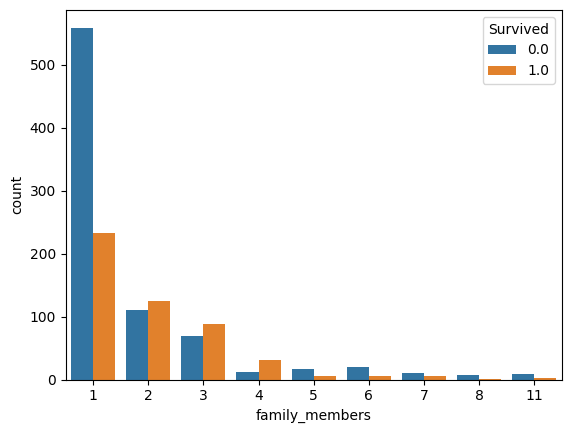

In [20]:
sns.countplot(x='family_members', hue='Survived', data=df)

Não é possível tomar grandes conclusões, pois a maioria das ocorrências são de pessoas que viajaram sozinhas. Com tudo, vamos checar as taxas de sobrevivência para cada grupo

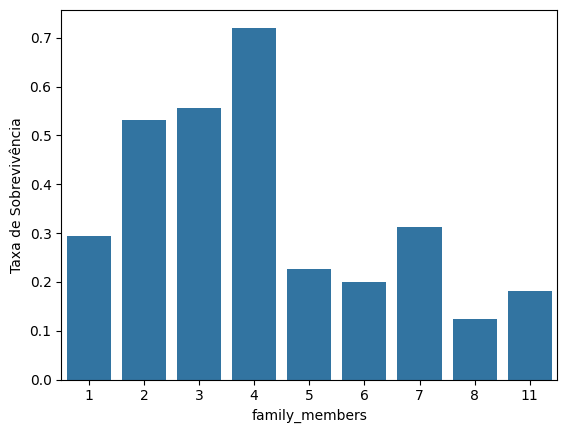

In [21]:
survival_rate = df.groupby('family_members')['Survived'].mean()

sns.barplot(data=survival_rate)
plt.ylabel('Taxa de Sobrevivência')
plt.xlabel('family_members')
plt.show()

Hipótese: Talvez grandes grupos tiveram difículdade de se separar, e por isso sua chance de sobrevivência foi menor. Não é possível comprovar isso devido ao número escasso de dados.   
Como o heatmap não mostra uma correlação forte entre membros da familia e sobrevivência, vamos testar para algo mais provável e tentar explicar porque tantas pessoas que viajavam sozinhas morreram. 

<Axes: xlabel='family_members', ylabel='count'>

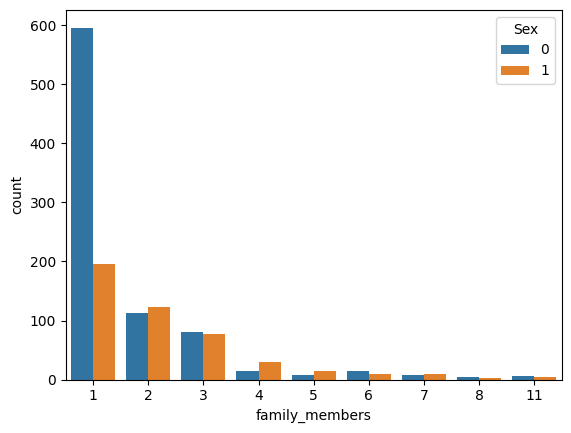

In [22]:
sns.countplot(x='family_members', hue='Sex', data=df)

A sobrevivência parece não correlacionar muito bem com o tamanho da familia, mas sim com o sexo do passageiro. A maioria eram homens viajando sozinhos, logo talvez houve uma priorização do resgate das mulheres em detrimento dos homens.  
  
Além do sexo, talvez as idades tenham discriminado os passageiros no momento de resgate. Vamos testar para crianças, adultos e idosos.

In [23]:
boys = df.loc[(df['Age'] <= 14) & (df['Sex'] == 0), 'Survived']
girls = df.loc[(df['Age'] <= 14) & (df['Sex'] == 1), 'Survived']

woman = df.loc[(df['Age'] > 14) & (df['Sex'] == 1), 'Survived']
men = df.loc[(df['Age'] > 14) & (df['Sex'] == 0), 'Survived']

old_woman = df.loc[(df['Age'] > 50) & (df['Sex'] == 1), 'Survived']
old_men = df.loc[(df['Age'] > 50) & (df['Sex'] == 0), 'Survived']

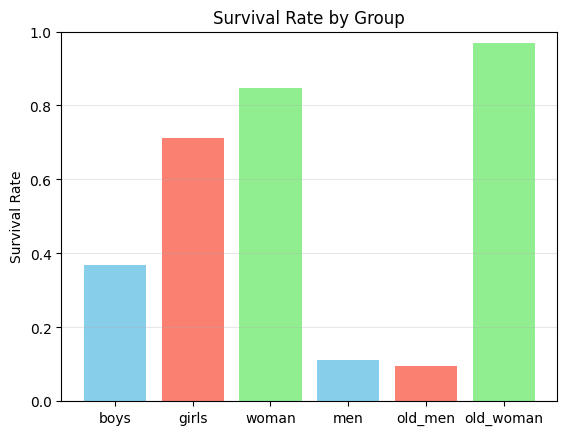

In [24]:
survival_rates = {
    'boys': boys.mean(),
    'girls': girls.mean(),
    'woman': woman.mean(),
    'men': men.mean(),
    'old_men': old_men.mean(),
    'old_woman': old_woman.mean()
}

# Plotando
plt.bar(survival_rates.keys(), survival_rates.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Group')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()

Mostrando assim que houve quase não houve distinção para homens velhos. Crianças também foram prioridade, mas mulheres de todas as idades foram priorizadas sobre homens de todas as idades. 

Por tanto de fato a preferência foi por salvar primeiro mulheres. Vamos ver se o mesmo vale segmentanto em classes de passagem.

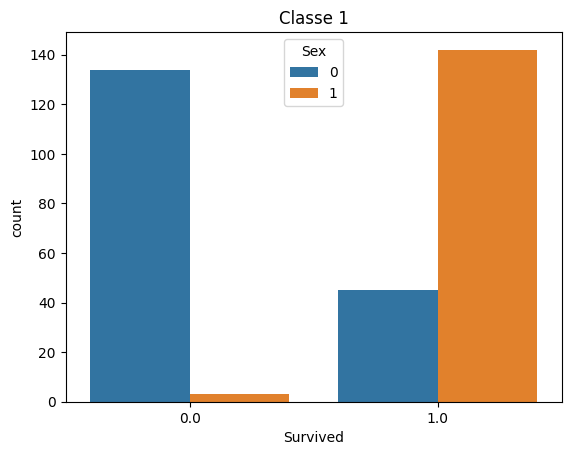

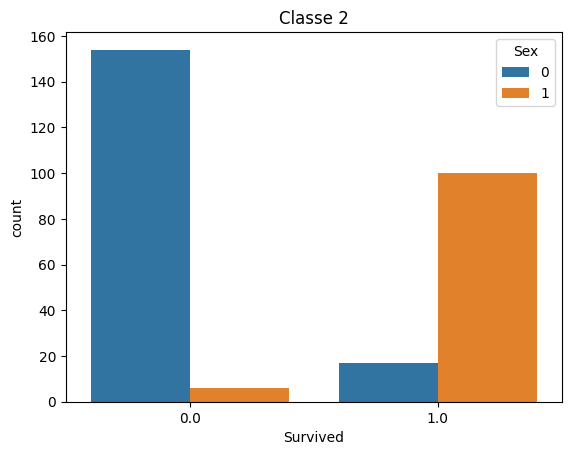

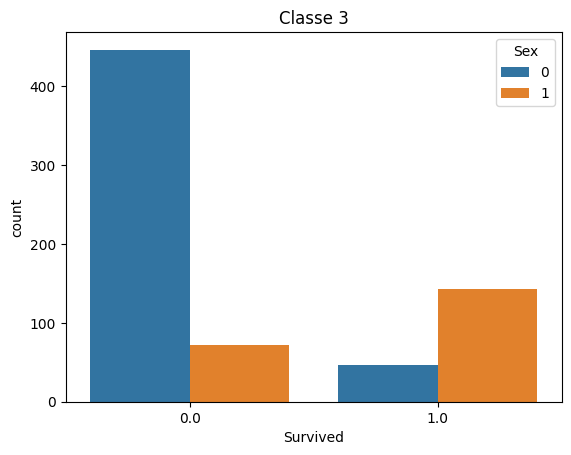

In [25]:
for pclass in sorted(df['Pclass'].unique()):
    sns.countplot(x='Survived', hue='Sex', data=df[df['Pclass'] == pclass])
    plt.title(f'Classe {pclass}')
    plt.show()

Como é possível perceber, para as mulheres 1 segunda classe houveram menos óbitos. Para os homens o mesmo se repete, aqueles com primeira classe tiveram chances um pouco mais elevadas de sobrevivência. Portanto a classe do passageiro está diretamente atrelado a suas chances do sobrevivência.  
  
Hipótese: Pessoas importantes foram resgatadas com prioridade.  
Para saber se eram de fato importântes, seria nessesária uma análise do título no nome de cada um.

## Conclusão 

Com base na análise realizada é foi possível determinar que:
* Sexo do passageiro é o maior determinantes de sobrevivência
* A idade é um fator mais significativo para crinças que para velhos
* Passageiros de primeira e segunda classe foram priorizados no geral

Dúvidas que restaram após a análise:
* Grandes grupos tem menos chances de sobreviver?
* Pessoas de primeira classe foram priorizadas no resgate porque eram mais influentes ou porque pagaram mais?
* Porque alguns conseguiram comprar passagens de primeira classe pelo valor de terceira classe? Porque foram convidadas?

